## Speaker Recognition using Vector Quantization
- Some terms and how to implement
    - **Codebook**: each category (speaker) has its own codebook, which is a set of codewords
    - **Codeword**: for each speaker, its feature vectors are clustered, and a codeword is the center of a cluster
    - **Pridict an unknown speaker**: compare with each codebook
        - a testing utter $X$, a codebook $C$
        - the distance between a code vector $x_i$ and a codebook $C$ is defined as 
          $d(x_i, C) = \min_{c_j \in C} d(x_i, c_j)$
        - the average distortion of $X$ and $C$ is
          $D(X, C) = \frac{1}{T}\sum_{i=1}^T d(x_i, C)$
- Clustering methods
  - **K-means**
  - Gaussian Mixture Model (GMM)

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('speaker_recognition').getOrCreate()

In [3]:
raw_df = spark.read.csv('/FileStore/tables/utter_MFCC.csv', inferSchema=True, header=True)

In [4]:
raw_df.printSchema()

root
-- _c0: integer (nullable = true)
-- utter_id: integer (nullable = true)
-- s_id: string (nullable = true)
-- MFCC_0: double (nullable = true)
-- MFCC_1: double (nullable = true)
-- MFCC_2: double (nullable = true)
-- MFCC_3: double (nullable = true)
-- MFCC_4: double (nullable = true)
-- MFCC_5: double (nullable = true)
-- MFCC_6: double (nullable = true)
-- MFCC_7: double (nullable = true)
-- MFCC_8: double (nullable = true)
-- MFCC_9: double (nullable = true)
-- MFCC_10: double (nullable = true)
-- MFCC_11: double (nullable = true)
-- MFCC_12: double (nullable = true)

In [5]:
from pyspark.sql import functions as func
from pyspark.ml import feature as feat
from pyspark.ml import Pipeline

In [6]:
sid_to_label = feat.StringIndexer(inputCol='s_id', outputCol='label')
concat_feat = feat.VectorAssembler(inputCols=raw_df.columns[3:], outputCol='features')

In [7]:
data_prep_pipe = Pipeline(stages=[sid_to_label, concat_feat])
data_prep = data_prep_pipe.fit(raw_df)
clean_data = data_prep.transform(raw_df)

In [8]:
train_utter, test_utter = clean_data.select('utter_id').distinct().randomSplit([0.75, 0.25])

In [9]:
train_df = clean_data.join(train_utter, clean_data.utter_id == train_utter.utter_id).select('label', 'features')
test_df = clean_data.join(test_utter, clean_data.utter_id == test_utter.utter_id).select('label', 'features', test_utter.utter_id)

In [10]:
def get_codewords(df, kmeans):
  
  kmeans_model = kmeans.fit(df)
  predicts = kmeans_model.transform(df)
  centers = kmeans_model.clusterCenters()
  
  return centers

In [11]:
def get_codebooks(df, label_vals, kmeans):
  
  codebooks = {}
    
  for label_val in label_vals:
    curr_df = df.filter(df.label == label_val)
    codewords = get_codewords(curr_df, kmeans)
    codebooks[label_val] = codewords
    print('Codebook {} is done.'.format(label_val))
  
  return codebooks

### Using clustering to generate codebooks
This step takes time when the data is large ince one codebook (speaker) needs a clustering process

In [13]:
from pyspark.ml.clustering import KMeans

In [14]:
label_vals = train_df.select('label').distinct().collect()
label_vals = [lv[0] for lv in label_vals]

k = 100
kmeans = KMeans().setK(k).setSeed(1)

codebooks = get_codebooks(train_df, label_vals, kmeans)

Codebook 8.0 is done.
Codebook 0.0 is done.
Codebook 7.0 is done.
Codebook 49.0 is done.
Codebook 29.0 is done.
Codebook 47.0 is done.
Codebook 42.0 is done.
Codebook 44.0 is done.
Codebook 35.0 is done.
Codebook 18.0 is done.
Codebook 1.0 is done.
Codebook 39.0 is done.
Codebook 34.0 is done.
Codebook 37.0 is done.
Codebook 25.0 is done.
Codebook 36.0 is done.
Codebook 41.0 is done.
Codebook 4.0 is done.
Codebook 23.0 is done.
Codebook 45.0 is done.
Codebook 31.0 is done.
Codebook 11.0 is done.
Codebook 21.0 is done.
Codebook 14.0 is done.
Codebook 48.0 is done.
Codebook 22.0 is done.
Codebook 3.0 is done.
Codebook 19.0 is done.
Codebook 46.0 is done.
Codebook 28.0 is done.
Codebook 2.0 is done.
Codebook 17.0 is done.
Codebook 38.0 is done.
Codebook 27.0 is done.
Codebook 10.0 is done.
Codebook 30.0 is done.
Codebook 40.0 is done.
Codebook 13.0 is done.
Codebook 33.0 is done.
Codebook 6.0 is done.
Codebook 20.0 is done.
Codebook 32.0 is done.
Codebook 24.0 is done.
Codebook 15.0 is done.
Codebook 5.0 is done.
Codebook 9.0 is done.
Codebook 26.0 is done.
Codebook 16.0 is done.
Codebook 12.0 is done.
Codebook 43.0 is done.

In [15]:
import numpy as np

dbutils.fs.rm('/FileStore/results/spkr-k=100.txt')

codebooks_list = {}
for key in codebooks:
  codebooks_list[key] = np.array(codebooks[key]).tolist()
dbutils.fs.put('/FileStore/results/spkr-k=100.txt', str(codebooks_list))

Wrote 1319883 bytes.
Out[13]: True

### Plot the codebooks using t-SNE

In [17]:
from sklearn.manifold import TSNE
import pandas as pd

In [18]:
frames = []
for label_val in label_vals:
  frames.append(pd.DataFrame(np.array(codebooks[label_val])))

In [19]:
all_codewords = pd.concat(frames)

In [20]:
codewords_embedded = TSNE(n_components=2).fit_transform(all_codewords)

In [21]:
import matplotlib.pyplot as plt

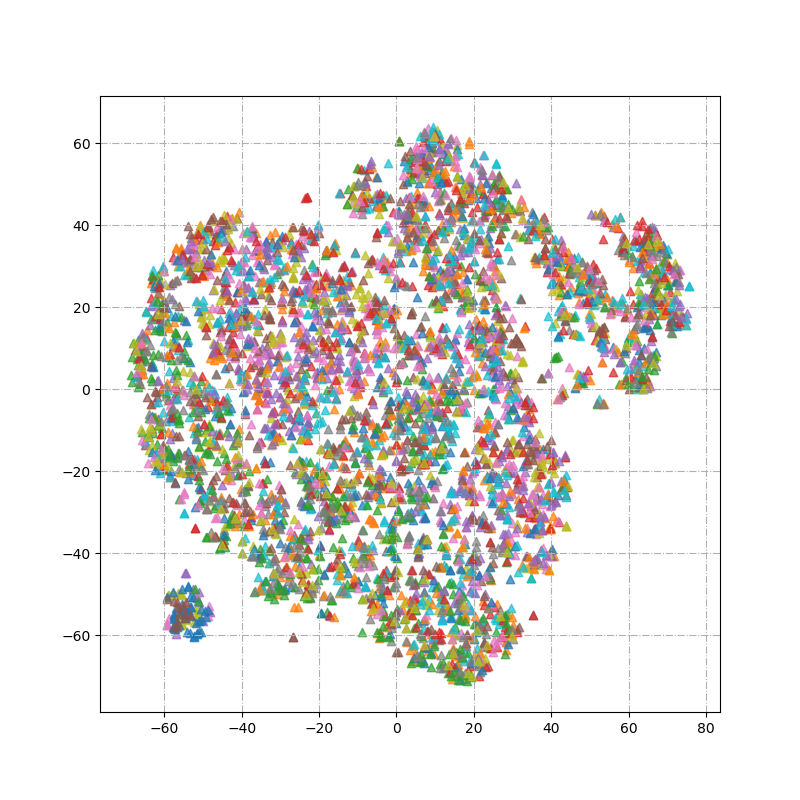

In [22]:
fig = plt.figure(figsize=(8, 8))
for i, label_vel in enumerate(label_vals[:]):
  plt.scatter(codewords_embedded[i*k:(i+1)*k, 0], codewords_embedded[i*k:(i+1)*k, 1], alpha=0.7, marker='^')
plt.grid(linestyle='-.')
display(fig)

In [23]:
test_rdd = test_df.rdd

In [24]:
from numpy.linalg import norm

In [25]:
results = None
for i, key in enumerate(codebooks):
  codewords = codebooks[key]
  test_rdd_dist = test_rdd.map(lambda line: (str(line[0]), str(line[2]), float(np.min(norm(line[1].toArray() - codewords, axis=1, ord=2)))))
  test_with_dist = test_rdd_dist.toDF(['label', 'utter_id', 'dist'])
  if i == 0:
    results = test_with_dist.groupBy('label', 'utter_id').mean().withColumn('codebook', func.lit(str(key)))
  else: 
    curr = test_with_dist.groupBy('label', 'utter_id').mean().withColumn('codebook', func.lit(str(key)))
    results = results.union(curr)

In [26]:
ret = results.groupBy('utter_id', 'label').min()
label_preds = ret.join(results, results['avg(dist)']==ret['min(avg(dist))']).select(ret.label, 'codebook').collect()

In [27]:
from sklearn import metrics
evl = np.array(label_preds, dtype='float').T
metrics.accuracy_score(evl[0], evl[1])

Out[24]: 0.9210858585858586